# Stage 1 Model: predict listing price based on listing features

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

from xgboost import XGBRegressor
import category_encoders as ce
import datetime
import joblib

[Python - How to Save and Load ML Models](https://www.kaggle.com/prmohanty/python-how-to-save-and-load-ml-models)

## Finalize features and target variable
- target variable is price

In [255]:
df = pd.read_csv('../../Large_Data/Listings_combined_cleaned.csv')
print(df.shape)
df.head()

(9825, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [256]:
df.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'price', 'availability_30', 'availability_60',
       'availability_90'],
      dtype='object')

In [257]:
# create X and y
X = df.drop(columns=['price','availability_30', 'availability_60','availability_90'])
y = df['price']

# create a 'random' column in X
X['random'] = np.random.random(X.shape[0])

# build the model
m1_pipe_xgb_base_random = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=400, max_depth=4, eta=0.03, reg_lambda=30, reg_alpha=30, random_state=42, n_jobs=-1))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7368, 36), (7368,), (2457, 36), (2457,))

In [258]:
# get the data shape after one hot encoding 

# https://contrib.scikit-learn.org/category_encoders/onehot.html
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')

X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
X_train_ohe.shape

(7368, 99)

In [259]:
# create train for EDA
train = df.loc[df.index.isin(X.index), :]
print(train.shape)
train.head()

(9825, 39)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,1,161.0,7,7,10
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,1,235.0,30,60,90
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,1,56.0,30,60,90
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,0,1,1,1,1,1,56.0,30,60,90
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,0,1,1,1,1,1,895.0,29,59,89


In [260]:
X_train.head()

,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,random
4852,Redwood City,San Mateo,Private room in residential home,4,2.0,2.0,1.0,shared,15,1125,...,63,0,0,1,0,1,1,1,1,0.996238
4052,Noe Valley,San Francisco,Private room in residential home,2,1.0,1.0,1.5,shared,2,7,...,6,6,2,0,1,0,0,0,1,0.424585
8104,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,3.0,shared,2,1125,...,67,18,1,1,1,1,1,1,1,0.253169
1396,Bernal Heights,San Francisco,Private room in guest suite,2,1.0,1.0,1.0,private,2,14,...,141,11,3,0,0,0,0,0,1,0.285947
7150,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,1.0,private,1,2,...,105,3,0,1,1,1,1,1,0,0.044503


## EDA

In [261]:
train.describe()

,accommodates,bedrooms,beds,bathrooms,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,...,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90
count,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,...,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000,9825.000000
mean,3.480305,1.593181,2.028702,1.416896,13.044784,569.837150,4.764960,4.814749,4.757261,4.880370,...,0.731501,0.707277,0.828601,0.828601,0.861272,0.875623,178.069313,11.231552,27.325293,46.218626
std,2.415604,0.975522,1.569959,0.826013,30.318371,514.153885,0.407623,0.379128,0.420152,0.327301,...,0.443201,0.455035,0.376877,0.376877,0.345680,0.330027,148.448029,11.269745,22.415682,32.691111
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,30.000000,4.710000,4.790000,4.690000,4.890000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,81.000000,0.000000,1.000000,13.000000
50%,2.000000,1.000000,1.000000,1.000000,3.000000,365.000000,4.880000,4.930000,4.890000,4.970000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,134.000000,8.000000,27.000000,51.000000
75%,4.000000,2.000000,3.000000,2.000000,30.000000,1125.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,219.000000,22.000000,49.000000,78.000000
max,16.000000,9.000000,27.000000,10.000000,1125.000000,1125.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000,30.000000,60.000000,90.000000


In [262]:
# Price

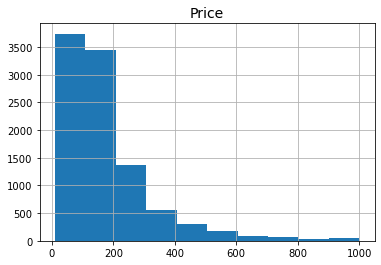

In [299]:
plt.figure(figsize=(6,4))
train['price'].hist()
plt.title('Price', fontsize=14);

plt.savefig('../Plots/price_hist.png')

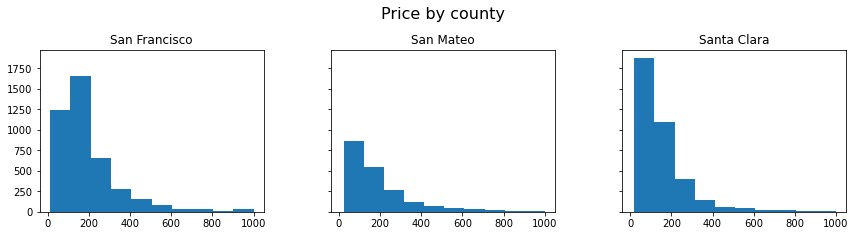

In [302]:
train.hist(column='price', by='county', figsize=(14,3), 
           layout=(1,3), xrot=0, legend=False, 
           sharex=True, sharey=True)
plt.suptitle('Price by county', x=0.5, y=1.1, fontsize=16)
;

plt.savefig('../Plots/price_bycounty_hist2.png', bbox_inches='tight')

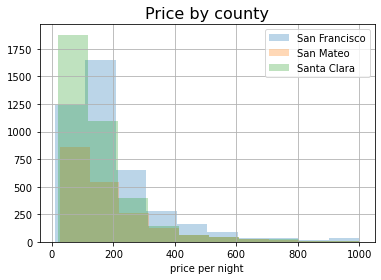

In [275]:
train.groupby('county')['price'].hist(alpha=0.3, legend=True)
plt.legend()
plt.title('Price by county', fontsize=16)
plt.xlabel('price per night');

plt.savefig('../Plots/price_bycounty_hist.png')

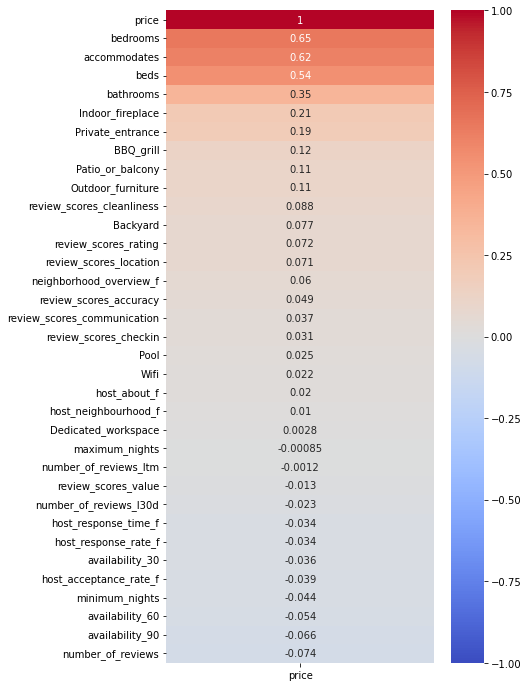

In [303]:
plt.figure(figsize=(6,12))
sns.heatmap(train.corr()[['price']].sort_values('price',ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
; 
plt.savefig('../Plots/corr_price_features_heat.png', bbox_inches='tight')

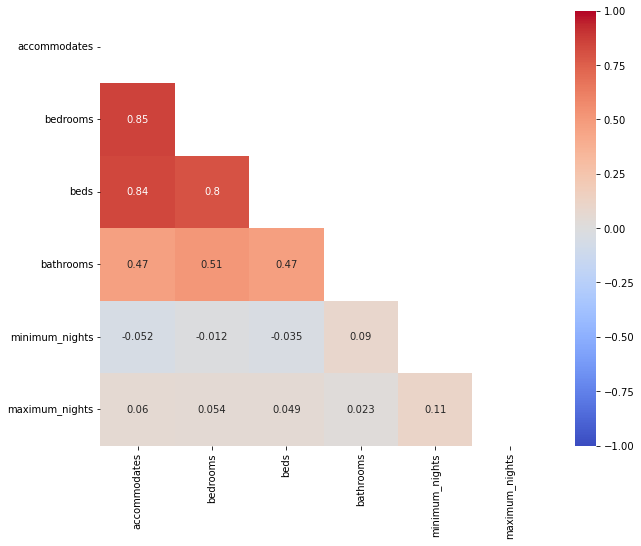

In [304]:
mask = np.zeros_like(train[['accommodates','bedrooms','beds','bathrooms','bathroom_type','minimum_nights','maximum_nights']].corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,8))
sns.heatmap(train[['accommodates','bedrooms','beds','bathrooms','bathroom_type','minimum_nights','maximum_nights']].corr(), 
            mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1);

plt.savefig('../Plots/corr_sizes_nights_heat.png', bbox_inches='tight')

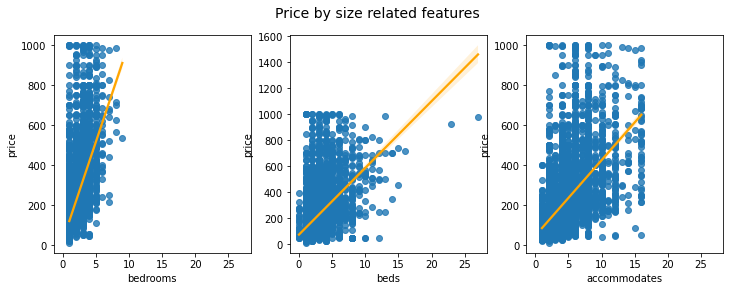

In [305]:
figure, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True)

ax1 = sns.regplot(x='bedrooms',     y='price', data=train, ax=axes[0], line_kws={'color':'orange'})
ax2 = sns.regplot(x='beds',         y='price', data=train, ax=axes[1], line_kws={'color':'orange'})
ax3 = sns.regplot(x='accommodates', y='price', data=train, ax=axes[2], line_kws={'color':'orange'})

plt.suptitle('Price by size related features', fontsize=14); 

plt.savefig('../Plots/corr_price_sizes_regplot.png', bbox_inches='tight')

**Observations**: 
1. Listing price is correlated with the number of bedrooms and beds and the number of people it can accommodate. 
2. The number of beds, bedrooms and people the unit can accommodate are highly correlated.

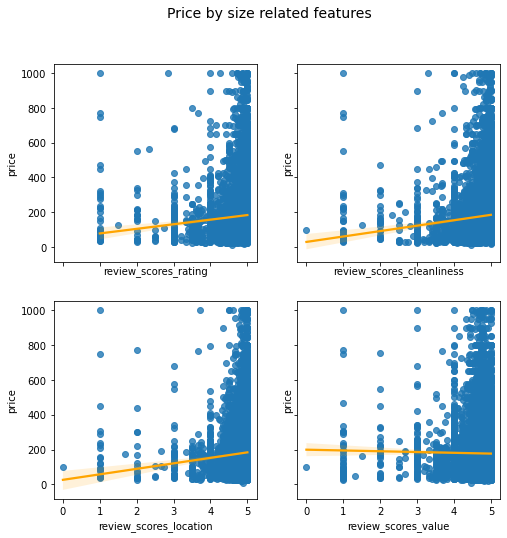

In [306]:
figure, axes = plt.subplots(2, 2, figsize=(8,8), sharex=True, sharey=True)

ax1 = sns.regplot(x='review_scores_rating',      y='price', data=train, ax=axes[0,0], line_kws={'color':'orange'})
ax2 = sns.regplot(x='review_scores_cleanliness', y='price', data=train, ax=axes[0,1], line_kws={'color':'orange'})
ax3 = sns.regplot(x='review_scores_location',       y='price', data=train, ax=axes[1,0], line_kws={'color':'orange'})
ax3 = sns.regplot(x='review_scores_value',       y='price', data=train, ax=axes[1,1], line_kws={'color':'orange'})

plt.suptitle('Price by size related features', fontsize=14); 

plt.savefig('../Plots/corr_price_reviewscores_regplot.png', bbox_inches='tight')

In [ ]:
# price by categorical 

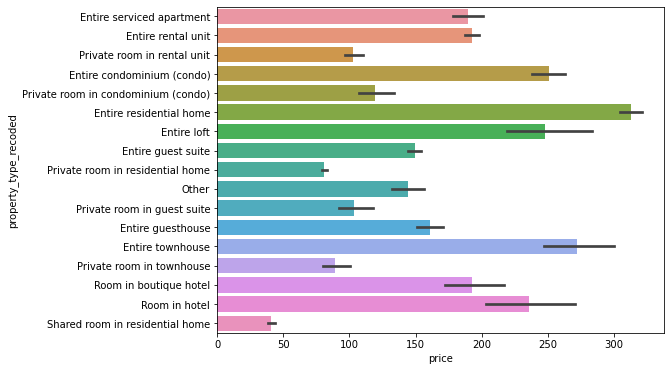

In [291]:
plt.figure(figsize=(8, 6))
sns.barplot(y='property_type_recoded', x='price', data=train, orient='h');

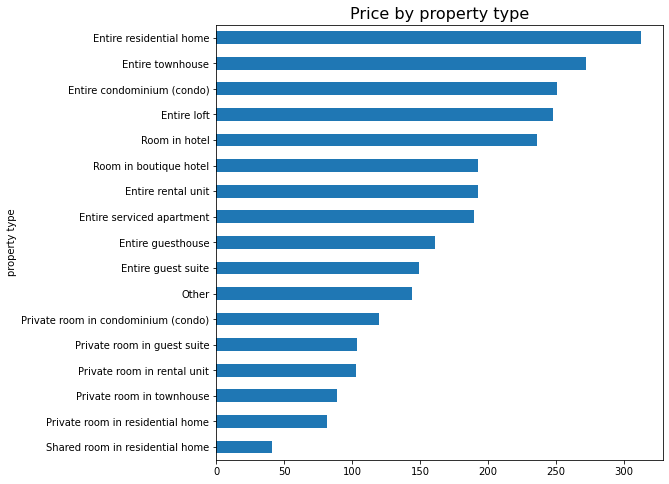

In [309]:
plt.figure(figsize=(8,8))
train.groupby('property_type_recoded').mean()['price'].sort_values(ascending=True).plot.barh()
plt.ylabel('property type')
plt.title('Price by property type', fontsize=16); 

plt.savefig('../Plots/price_propertytype_barh.png', bbox_inches='tight')

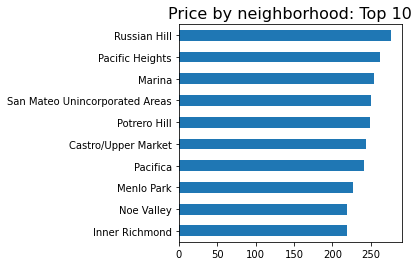

In [308]:
plt.figure(figsize=(4,4))
train.groupby('neighborhood_recoded').mean()['price'].sort_values(ascending=True).tail(10).plot.barh()
plt.title('Price by neighborhood: Top 10', fontsize=16)
plt.ylabel(None); 

plt.savefig('../Plots/price_neighborhood_top10_barh.png', bbox_inches='tight')

## Modeling

In [8]:
print(X_train.shape)
X_train.head()

(7368, 36)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,neighborhood_overview_f,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,random
4852,Redwood City,San Mateo,Private room in residential home,4,2.0,2.0,1.0,shared,15,1125,...,63,0,0,1,0,1,1,1,1,0.671808
4052,Noe Valley,San Francisco,Private room in residential home,2,1.0,1.0,1.5,shared,2,7,...,6,6,2,0,1,0,0,0,1,0.046063
8104,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,3.0,shared,2,1125,...,67,18,1,1,1,1,1,1,1,0.014837
1396,Bernal Heights,San Francisco,Private room in guest suite,2,1.0,1.0,1.0,private,2,14,...,141,11,3,0,0,0,0,0,1,0.310689
7150,San Jose,Santa Clara,Private room in residential home,2,1.0,1.0,1.0,private,1,2,...,105,3,0,1,1,1,1,1,0,0.625515


In [9]:
# save m1_X_train
X_train.to_csv('../Data/m1_X_train.csv')

(7368, 99)

In [11]:
#X_train_ohe.columns

### Baseline model

In [12]:
# train set
print(f'Average listing price (train): {round(y_train.mean(), 2)}')
price_pred_base_train = np.full((y_train.shape[0], 1), y_train.mean())

price_pred_base_mse_train = metrics.mean_squared_error(y_train, price_pred_base_train)
print(f'price_pred_base_mse_train: {round(price_pred_base_mse_train, 4)}')
print()

# test set
print(f'Average listing price (test): {round(y_test.mean(), 2)}')
price_pred_base_test = np.full((y_test.shape[0], 1), y_test.mean())

price_pred_base_mse_test = metrics.mean_squared_error(y_test, price_pred_base_test)
print(f'price_pred_base_mse_test: {round(price_pred_base_mse_test, 4)}')

Average listing price (train): 177.53
price_pred_base_mse_train: 21698.0376

Average listing price (test): 179.68
price_pred_base_mse_test: 23040.302


### Random Forest regressor

#### Default parameter values

In [13]:
m1_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_base.fit(X_train, y_train)
m1_pipe_rf_base_pred_train = m1_pipe_rf_base.predict(X_train)
m1_pipe_rf_base_pred_test = m1_pipe_rf_base.predict(X_test)

m1_pipe_rf_base_R2_train = m1_pipe_rf_base.score(X_train, y_train)
m1_pipe_rf_base_R2_test = m1_pipe_rf_base.score(X_test, y_test)
print('m1_pipe_rf_base_R2_train: ', round(m1_pipe_rf_base_R2_train, 4))
print('m1_pipe_rf_base_R2_test: ', round(m1_pipe_rf_base_R2_test, 4))

m1_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_rf_base_pred_train)
m1_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_rf_base_pred_test)
print('m1_pipe_rf_base_mse_train', round(m1_pipe_rf_base_mse_train, 4))
print('m1_pipe_rf_base_mse_test', round(m1_pipe_rf_base_mse_test, 4))

m1_pipe_rf_base_R2_train:  0.9497
m1_pipe_rf_base_R2_test:  0.6574
m1_pipe_rf_base_mse_train 1090.7954
m1_pipe_rf_base_mse_test 7894.4594


**Observation**: The model is overfit.

In [15]:
m1_pipe_rf_base_feature_importance = pd.DataFrame({'feature': m1_pipe_rf_base['ohe'].get_feature_names(),
                                         'importance': m1_pipe_rf_base['rf'].feature_importances_})

m1_pipe_rf_base_feature_importance.to_csv('../Data/m1_pipe_rf_base_feature_importance.csv', index=False)
m1_pipe_rf_base_feature_importance.sort_values('importance', ascending=False).head(10)

,feature,importance
66,bedrooms,0.392925
68,bathrooms,0.066267
71,minimum_nights,0.038149
98,random,0.030087
82,review_scores_rating,0.029460
88,review_scores_value,0.028554
87,review_scores_location,0.025528
89,number_of_reviews,0.024506
65,accommodates,0.023891
72,maximum_nights,0.023606


**Observation**: There are only 3 features that seem more important than the 'random' variable. This looks weird.

#### GridSearchCV

##### with all features

In [18]:
# build the model
m1_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_params = {
    'rf__n_estimators': [400, 500, 600],
    'rf__max_depth': [6, 8, 10, 14],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5],
    #'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [30, 60]
}
    
m1_gs_rf = GridSearchCV(m1_pipe_rf,
                        m1_pipe_rf_params,
                        cv=5)

# train the model
print(datetime.datetime.now())
m1_gs_rf.fit(X_train, y_train)
print(datetime.datetime.now())

# predict
m1_gs_rf_pred_train = m1_gs_rf.predict(X_train)
m1_gs_rf_pred_test = m1_gs_rf.predict(X_test)

# evaluate
m1_gs_rf_R2_train = m1_gs_rf.score(X_train, y_train)
m1_gs_rf_R2_test = m1_gs_rf.score(X_test, y_test)
print('m1_gs_rf_R2_train: ', round(m1_gs_rf_R2_train, 4))
print('m1_gs_rf_R2_test:  ', round(m1_gs_rf_R2_test, 4))

m1_gs_rf_mse_train = metrics.mean_squared_error(y_train, m1_gs_rf_pred_train)
m1_gs_rf_mse_test = metrics.mean_squared_error(y_test, m1_gs_rf_pred_test)
print('m1_gs_rf_mse_train: ', round(m1_gs_rf_mse_train, 4))
print('m1_gs_rf_mse_test:  ', round(m1_gs_rf_mse_test, 4))

m1_gs_rf.best_estimator_

2022-02-05 08:14:08.508316
2022-02-05 08:20:54.998836
m1_gs_rf_R2_train:  0.8152
m1_gs_rf_R2_test:   0.6465
m1_gs_rf_mse_train:  4010.0584
m1_gs_rf_mse_test:   8145.2011


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=14, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=600, n_jobs=-1,
                                       random_state=42))])

In [22]:
# feature importance
m1_gs_rf_feature_importance = pd.DataFrame({'feature': m1_gs_rf.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m1_gs_rf.best_estimator_['rf'].feature_importances_})

m1_gs_rf_feature_importance.to_csv('../Data/m1_gs_rf_feature_importance.csv', index=False)
m1_gs_rf_feature_importance.sort_values('importance', ascending=False).head(20)

# There are 14 features that are more important than the 'random' feature

,feature,importance
66,bedrooms,0.347872
65,accommodates,0.125251
68,bathrooms,0.064252
67,beds,0.037408
71,minimum_nights,0.035539
82,review_scores_rating,0.028545
88,review_scores_value,0.025348
87,review_scores_location,0.024471
69,bathroom_type_shared,0.023052
72,maximum_nights,0.022982


In [21]:
# correlation between actual and predicted prices

import scipy
scipy.stats.pearsonr(y_test, m1_gs_rf_pred_test)

(0.8086121404710693, 0.0)

##### with top 50 features

In [25]:
# retrain the model after dropping features based on importance

# top-50 feature list
feature_list = m1_gs_rf_feature_importance.sort_values('importance', ascending=False).head(51)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()



# build the model
m1_pipe_rf_top = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_rf_top_params = {
    'rf__n_estimators': [400, 500, 600],
    'rf__max_depth': [6, 8, 10, 14],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5],
    #'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [30, 50]
}
    
m1_gs_rf_top = GridSearchCV(m1_pipe_rf_top,
                        m1_pipe_rf_top_params,
                        cv=5)

# train the model
print(datetime.datetime.now())
m1_gs_rf_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())

# predict
m1_gs_rf_top_pred_train = m1_gs_rf_top.predict(X_train_ohe_top)
m1_gs_rf_top_pred_test = m1_gs_rf_top.predict(X_test_ohe_top)

# evaluate
m1_gs_rf_top_R2_train = m1_gs_rf_top.score(X_train_ohe_top, y_train)
m1_gs_rf_top_R2_test = m1_gs_rf_top.score(X_test_ohe_top, y_test)
print('m1_gs_rf_top_R2_train: ', round(m1_gs_rf_top_R2_train, 4))
print('m1_gs_rf_top_R2_test:  ', round(m1_gs_rf_top_R2_test, 4))

m1_gs_rf_top_mse_train = metrics.mean_squared_error(y_train, m1_gs_rf_top_pred_train)
m1_gs_rf_top_mse_test = metrics.mean_squared_error(y_test, m1_gs_rf_top_pred_test)
print('m1_gs_rf_top_mse_train: ', round(m1_gs_rf_top_mse_train, 4))
print('m1_gs_rf_top_mse_test:  ', round(m1_gs_rf_top_mse_test, 4))

m1_gs_rf_top.best_estimator_

2022-02-05 09:05:22.274964
2022-02-05 09:12:52.702961
m1_gs_rf_top_R2_train:  0.8126
m1_gs_rf_top_R2_test:   0.646
m1_gs_rf_top_mse_train:  4065.5202
m1_gs_rf_top_mse_test:   8155.9516


Pipeline(steps=[('ohe', OneHotEncoder(cols=[], use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=14, max_features=30,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=600, n_jobs=-1,
                                       random_state=42))])

**Observation**: The model with the top 50 features performed similarly as the model with all of the features.

#### Save m1_gs_rf and m1_gs_rf_top50 model with Joblib

In [247]:
import joblib

# save m1_gs_rf and m1_gs_rf_top
joblib.dump(m1_gs_rf, '../Models/m1_gs_rf.pkl')
joblib.dump(m1_gs_rf, '../Models/m1_gs_rf_top.pkl')

# reload 
#m1_gs_rf_joblib = joblib.load(m1_gs_rf_joblib_filename)

# predict & evaluate
#m1_gs_rf_joblib_pred_test = m1_gs_rf_joblib.predict(X_test)
#m1_gs_rf_joblib.score(X_test, y_test)

['../Models/m1_gs_rf_top.pkl']

### XGBoost 

#### Default parameter values

In [29]:
X_train.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'random'],
      dtype='object')

In [27]:
m1_pipe_xgb_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=1))
])

m1_pipe_xgb_base.fit(X_train, y_train)

m1_pipe_xgb_base_pred_train = m1_pipe_xgb_base.predict(X_train)
m1_pipe_xgb_base_pred_test = m1_pipe_xgb_base.predict(X_test)


m1_pipe_xgb_base_R2_train = m1_pipe_xgb_base.score(X_train, y_train)
m1_pipe_xgb_base_R2_test = m1_pipe_xgb_base.score(X_test, y_test)
print('m1_pipe_xgb_base_R2_train: ', round(m1_pipe_xgb_base_R2_train, 4))
print('m1_pipe_xgb_base_R2_test: ', round(m1_pipe_xgb_base_R2_test, 4))

m1_pipe_xgb_base_mse_train = metrics.mean_squared_error(y_train, m1_pipe_xgb_base_pred_train)
m1_pipe_xgb_base_mse_test = metrics.mean_squared_error(y_test, m1_pipe_xgb_base_pred_test)
print('m1_pipe_xgb_base_mse_train: ', round(m1_pipe_xgb_base_mse_train, 4))
print('m1_pipe_xgb_base_mse_test: ', round(m1_pipe_xgb_base_mse_test, 4))



m1_pipe_xgb_base_R2_train:  0.9448
m1_pipe_xgb_base_R2_test:  0.6569
m1_pipe_xgb_base_mse_train:  1197.3008
m1_pipe_xgb_base_mse_test:  7905.0643


['../Models/m1_pipe_xgb_base_joblib.pkl']

In [248]:
# save m1_gs_rf

# import joblib
joblib.dump(m1_pipe_xgb_base, '../Models/m1_pipe_xgb_base_joblib.pkl')

['../Models/m1_pipe_xgb_base_joblib.pkl']

In [30]:
# feature importance
m1_pipe_xgb_base_feature_importance = pd.DataFrame({'feature': m1_pipe_xgb_base['ohe'].get_feature_names(),
                                             'importance': m1_pipe_xgb_base['xgb'].feature_importances_})

m1_pipe_xgb_base_feature_importance.to_csv('../Data/m1_pipe_xgb_base_feature_importance.csv')
m1_pipe_xgb_base_feature_importance.sort_values('importance', ascending=False).head(21)

# There are 59 features that are more important than the 'random' column.

,feature,importance
66,bedrooms,0.247459
69,bathroom_type_shared,0.058778
47,county_Santa Clara,0.039802
46,county_San Francisco,0.035981
68,bathrooms,0.031624
48,property_type_recoded_Private room in resident...,0.023782
24,neighborhood_recoded_Russian Hill,0.023647
71,minimum_nights,0.018377
79,Indoor_fireplace,0.015001
65,accommodates,0.013322


**Observation**: R2 for the test set is slightly higher than the random forest models but the model is more overfitted than those models, as its R2 for the train set is much higher.

**Decision**: Drop some features based on feature importance.

In [36]:
# retrain the model with top 60 features 

# top-60 feature list
feature_list = m1_pipe_xgb_base_feature_importance.sort_values('importance', ascending=False).head(61)['feature']
# feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()

# build this model
m1_pipe_xgb_base_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=400, max_depth=4, eta=0.03, reg_lambda=30, reg_alpha=30, 
                                  random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m1_pipe_xgb_base_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m1_pipe_xgb_base_top_pred_train = m1_pipe_xgb_base_top.predict(X_train_ohe_top)
m1_pipe_xgb_base_top_pred_test = m1_pipe_xgb_base_top.predict(X_test_ohe_top)

# evaluate
m1_pipe_xgb_base_top_R2_train = m1_pipe_xgb_base_top.score(X_train_ohe_top, y_train)
m1_pipe_xgb_base_top_R2_test = m1_pipe_xgb_base_top.score(X_test_ohe_top, y_test)
print('m1_pipe_xgb_base_top_R2_train: ', round(m1_pipe_xgb_base_top_R2_train, 4))
print('m1_pipe_xgb_base_top_R2_test: ', round(m1_pipe_xgb_base_top_R2_test, 4))

m1_pipe_xgb_base_top_mse_train = metrics.mean_squared_error(y_train, m1_pipe_xgb_base_top_pred_train)
m1_pipe_xgb_base_top_mse_test = metrics.mean_squared_error(y_test, m1_pipe_xgb_base_top_pred_test)
print('m1_pipe_xgb_base_top_mse_train', round(m1_pipe_xgb_base_top_mse_train, 4))
print('m1_pipe_xgb_base_top_mse_test', round(m1_pipe_xgb_base_top_mse_test, 4))


2022-02-05 09:47:47.664965
2022-02-05 09:47:50.207980

m1_pipe_xgb_base_top_R2_train:  0.7166
m1_pipe_xgb_base_top_R2_test:  0.6564
m1_pipe_xgb_base_top_mse_train 6149.8961
m1_pipe_xgb_base_top_mse_test 7916.0522


In [38]:
# feature importance
m1_pipe_xgb_base_top_feature_importance = pd.DataFrame({'feature': feature_list,
                                             'importance': m1_pipe_xgb_base_top['xgb'].feature_importances_})

m1_pipe_xgb_base_top_feature_importance.to_csv('../Data/m1_pipe_xgb_base_top_feature_importance.csv')
m1_pipe_xgb_base_top_feature_importance.sort_values('importance', ascending=False).head(10)

# There are 55 features that are more important than 'random'.

,feature,importance
66,bedrooms,0.392505
65,accommodates,0.064387
69,bathroom_type_shared,0.057862
48,property_type_recoded_Private room in resident...,0.032250
46,county_San Francisco,0.031958
47,county_Santa Clara,0.023798
68,bathrooms,0.022296
79,Indoor_fireplace,0.019577
71,minimum_nights,0.017855
82,review_scores_rating,0.014829


#### GridSearchCV

##### with all features

In [39]:
# build the model
m1_pipe_xgb = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m1_pipe_xgb_params = {
    'xgb__n_estimators': [300,400,500],
    'xgb__eta': [0.02, 0.03, 0.05],
    'xgb__reg_lambda': [20, 30],
    #'xgb__reglalpha': [20, 30],
    'xgb__max_depth': [4,5,6,7]
}

m1_gs_xgb = GridSearchCV(m1_pipe_xgb,
                         m1_pipe_xgb_params, 
                         cv = 5)

# train the model
print(datetime.datetime.now())
m1_gs_xgb.fit(X_train, y_train)
print(datetime.datetime.now())
print()

# predict
m1_gs_xgb_pred_train = m1_gs_xgb.predict(X_train)
m1_gs_xgb_pred_test = m1_gs_xgb.predict(X_test)

# evaluate
m1_gs_xgb_R2_train = m1_gs_xgb.score(X_train, y_train)
m1_gs_xgb_R2_test = m1_gs_xgb.score(X_test, y_test)
print(f'm1_gs_xgb_R2_train: {round(m1_gs_xgb_R2_train, 4)}')
print(f'm1_gs_xgb_R2_test: {round(m1_gs_xgb_R2_test, 4)}')

m1_gs_xgb_mse_train = metrics.mean_squared_error(y_train, m1_gs_xgb_pred_train)
m1_gs_xgb_mse_test = metrics.mean_squared_error(y_test, m1_gs_xgb_pred_test)
print(f'm1_gs_xgb_mse_train: {round(m1_gs_xgb_mse_train)}')
print(f'm1_gs_xgb_mse_test: {round(m1_gs_xgb_mse_test)}')

m1_gs_xgb.best_estimator_

2022-02-05 09:50:04.830292
2022-02-05 10:17:29.372368

m1_gs_xgb_R2_train: 0.8449272486632081
m1_gs_xgb_R2_test: 0.6907390421490873
m1_gs_xgb_mse_train: 3364.774384684616
m1_gs_xgb_mse_test: 7125.465865878826


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.05, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.0500000007, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=42, reg_alpha=0, reg_lambda=20,
               

In [40]:
# feature importance
m1_gs_xgb_feature_importance = pd.DataFrame({'feature': m1_gs_xgb.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m1_gs_xgb.best_estimator_['xgb'].feature_importances_})

m1_gs_xgb_feature_importance.to_csv('../Data/m1_gs_xgb_feature_importance.csv')
m1_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(20)

# There are 71 features that are more important than the 'random' column.

,feature,importance
66,bedrooms,0.355864
46,county_San Francisco,0.038140
65,accommodates,0.035429
69,bathroom_type_shared,0.033174
68,bathrooms,0.028085
47,county_Santa Clara,0.022299
48,property_type_recoded_Private room in resident...,0.016714
11,neighborhood_recoded_Santa Clara,0.014667
21,neighborhood_recoded_San Mateo Unincorporated ...,0.013412
71,minimum_nights,0.012584


In [249]:
# Save this model
joblib.dump(m1_gs_xgb, '../Models/m1_gs_xgb.pkl')

['../Models/m1_gs_xgb.pkl']

##### with top 50 features

In [46]:
# retrain the model with top 50 features 

# top-50 feature list
feature_list = m1_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(51)['feature']
#feature_list = [feature for feature in feature_list if feature != 'random']


# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()


# build the model
m1_pipe_xgb_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m1_gs_xgb_top_params = {
    'xgb__n_estimators': [300,400,500],
    'xgb__eta': [0.02, 0.03, 0.05],
    'xgb__reg_lambda': [20, 30],
    #'xgb__reglalpha': [20, 30],
    'xgb__max_depth': [4,5,6,7]
}

m1_gs_xgb_top = GridSearchCV(m1_pipe_xgb_top,
                         m1_gs_xgb_top_params, 
                         cv = 5)

# train the model
print(datetime.datetime.now())
m1_gs_xgb_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m1_gs_xgb_top_pred_train = m1_gs_xgb_top.predict(X_train_ohe_top)
m1_gs_xgb_top_pred_test = m1_gs_xgb_top.predict(X_test_ohe_top)

# evaluate
m1_gs_xgb_top_R2_train = m1_gs_xgb_top.score(X_train_ohe_top, y_train)
m1_gs_xgb_top_R2_test = m1_gs_xgb_top.score(X_test_ohe_top, y_test)
print(f'm1_gs_xgb_top_R2_train: {m1_gs_xgb_top_R2_train}')
print(f'm1_gs_xgb_top_R2_test: {m1_gs_xgb_top_R2_test}')

m1_gs_xgb_top_mse_train = metrics.mean_squared_error(y_train, m1_gs_xgb_top_pred_train)
m1_gs_xgb_top_mse_test = metrics.mean_squared_error(y_test, m1_gs_xgb_top_pred_test)
print(f'm1_gs_xgb_top_mse_train: {m1_gs_xgb_top_mse_train}')
print(f'm1_gs_xgb_top_mse_test: {m1_gs_xgb_top_mse_test}')

m1_gs_xgb.best_estimator_

2022-02-05 11:04:39.907782
2022-02-05 11:22:16.369313

m1_gs_xgb_top_R2_train: 0.8001587639524999
m1_gs_xgb_top_R2_test: 0.6849093850581075
m1_gs_xgb_top_mse_train: 4336.162647917143
m1_gs_xgb_top_mse_test: 7259.78292581492


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.05, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.0500000007, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=500,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=42, reg_alpha=0, reg_lambda=20,
               

In [49]:
# feature importance
m1_gs_xgb_top_feature_importance = pd.DataFrame({'feature': X_train_ohe_top.columns,
                                         'importance': m1_gs_xgb_top.best_estimator_['xgb'].feature_importances_})

m1_gs_xgb_top_feature_importance.to_csv('../Data/m1_gs_xgb_top_feature_importance.csv')
m1_gs_xgb_top_feature_importance.sort_values('importance', ascending=False).head(20)

# The 'random' column is not included in this list as it's less important than those features in the list.

,feature,importance
0,bedrooms,0.268157
3,bathroom_type_shared,0.058463
2,accommodates,0.038477
1,county_San Francisco,0.037378
4,bathrooms,0.029558
6,property_type_recoded_Private room in resident...,0.025859
20,neighborhood_recoded_Russian Hill,0.024170
8,neighborhood_recoded_San Mateo Unincorporated ...,0.021557
18,neighborhood_recoded_San Jose,0.020661
10,neighborhood_recoded_Pacific Heights,0.019952


In [144]:
X_train_ohe_top.to_csv('../Data/m1_X_train_ohe_top.csv', index=False)

In [251]:
# Save this model
joblib.dump(m1_gs_xgb_top, '../Models/m1_gs_xgb_top.pkl')

['../Models/m1_gs_xgb_top.pkl']

**Observation**: The XGBoost + GridSearchCV model with the top-50 important features has a comparable R2 for the test set but lower for the train set compared to the same model with all of the features.

**Decision**: This model (m1_gs_xgb_top: XGBoost + GridSearchCV model with the top-50) will be used to predict listing price.

## Predict with mock input data

In [117]:
# Create mock input data and format it as needed by the model
input_data = {'county': 'San Francisco',
              'neighborhood_recoded': 'Russian Hill', 
              'property_type_recoded': 'Entire residential home', 
              'accommodates': 6, 
              'bedrooms': 3, 
              'beds': 3,
              'bathrooms': 2.5, 
              'bathroom_type': 'private', 
              'minimum_nights': 1, 
              'maximum_nights': 3,
              'Wifi': 1, 
              'Dedicated_workspace': 0,
              'Private_entrance': 0, 
              'Patio_or_balcony': 1, 
              'Backyard': 1, 
              'BBQ_grill': 1, 
              'Outdoor_furniture': 1,
              'Indoor_fireplace': 0, 
              'Pool': 1, 
              'review_scores_rating': 4.8,
              'review_scores_accuracy': 4.8, 
              'review_scores_cleanliness': 4.8,
              'review_scores_checkin': 4.8,
              'review_scores_communication': 4.8,
              'review_scores_location': 4.8, 
              'review_scores_value': 4.8, 
              'number_of_reviews': 4.8,
              'number_of_reviews_ltm': 20, 
              'number_of_reviews_l30d': 5,
              'neighborhood_overview_f': 1, 
              'host_about_f': 1, 
              'host_response_time_f': 0,
              'host_response_rate_f': 0, 
              'host_acceptance_rate_f': 0,
              'host_neighbourhood_f': 0
}
input_data_df = pd.DataFrame(input_data, index=[0])

# one hot encoding - even though the shape and values don't change, the column names do change
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
input_data_df_ohe = ohe.fit_transform(input_data_df)
print(f'shape of the input data after ohe: {input_data_df_ohe.shape}')
# input_data_df_ohe
print(f'shape of the required input data: (1, {X_train_ohe_top.shape[1]})')

# take the columns in the input data that are needed in the model
input_data_df_ohe_useful = input_data_df_ohe[X_train_ohe_top.columns.intersection(input_data_df_ohe.columns)]
print(f'shape of useful input data: {input_data_df_ohe_useful.shape})')

# create feature_list_left - the columns which are in prediction model but not in the input data
# because they are all ohe columns, they are just filled with 0 
feature_list_left = set(X_train_ohe_top.columns).difference(input_data_df_ohe.columns)
fillin_data_df = pd.DataFrame(np.zeros([1, len(feature_list_left)]), columns=feature_list_left, index=[0])
print(f'shape of the fillin data (to meet the model requirement): {fillin_data_df.shape}')

input_data_df_final = pd.concat((input_data_df_ohe_useful, fillin_data_df), axis=1)
print(f'the shape of the input data ready for modeling: {input_data_df_final.shape}')
input_data_df_final

shape of the input data after ohe: (1, 35)
shape of the required input data: (1, 51)
shape of useful input data: (1, 21))
shape of the fillin data (to meet the model requirement): (1, 30)
the shape of the input data ready for modeling: (1, 51)


,bedrooms,county_San Francisco,accommodates,bathrooms,minimum_nights,Pool,Wifi,neighborhood_recoded_Russian Hill,Indoor_fireplace,review_scores_value,...,neighborhood_recoded_San Jose,neighborhood_recoded_Sunnyvale,neighborhood_recoded_Bernal Heights,neighborhood_recoded_San Mateo Unincorporated Areas,neighborhood_recoded_Campbell,property_type_recoded_Private room in residential home,neighborhood_recoded_Bayview,county_Santa Clara,neighborhood_recoded_South of Market,neighborhood_recoded_South San Francisco
0,3,1,6,2.5,1,1,1,1,0,4.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# load m1_gs_rf
m1_gs_xgb_top_joblib = joblib.load('../Models/m1_gs_xgb_top.pkl')

# predict
m1_gs_xgb_top_joblib_pred_input = m1_gs_xgb_top_joblib.predict(input_data_df_final)[0]
print('The predicted listing price is', round(m1_gs_xgb_top_joblib_pred_input, 2), 'dollars.')

The predicted listing price is 273.29 dollars.


# Stage 2 Model: predict 30-day vacancy 
- with unit features, listing price and predicted price

In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics

from xgboost import XGBRegressor

import category_encoders as ce
import datetime 
import joblib

## Finalize features and label

In [313]:
df = pd.read_csv('../../Large_Data/Listings_combined_cleaned.csv')
print(df.shape)
#df.head()

temp = pd.read_csv('../Data/m1_X_train_ohe_top.csv')
print(temp.shape)
#temp.head()

(9825, 39)
(7368, 51)


In [314]:
df.columns

Index(['neighborhood_recoded', 'county', 'property_type_recoded',
       'accommodates', 'bedrooms', 'beds', 'bathrooms', 'bathroom_type',
       'minimum_nights', 'maximum_nights', 'Wifi', 'Dedicated_workspace',
       'Patio_or_balcony', 'Backyard', 'BBQ_grill', 'Outdoor_furniture',
       'Indoor_fireplace', 'Private_entrance', 'Pool', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'neighborhood_overview_f', 'host_about_f', 'host_response_time_f',
       'host_response_rate_f', 'host_acceptance_rate_f',
       'host_neighbourhood_f', 'price', 'availability_30', 'availability_60',
       'availability_90'],
      dtype='object')

#### Create price_pred 

In [315]:
# create df_ohe to create price_pred
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
df_ohe = ohe.fit_transform(df)
#df_ohe
print(df_ohe.shape)

# take the columns that are needed in the model
#df_to_predict_price = df_ohe[df_ohe.columns.intersection(temp.columns)]
df_to_predict_price = df_ohe[temp.columns]
print(df_to_predict_price.shape)


# load m1_gs_
m1_gs_xgb_top_joblib = joblib.load('../Models/m1_gs_xgb_top.pkl')

# predict price
df['price_pred'] = m1_gs_xgb_top_joblib.predict(df_to_predict_price)
#df[['price','price_pred']]
#print(metrics.r2_score(df['price'], df['price_pred']))
#print(metrics.mean_squared_error(df['price'], df['price_pred']))

(9825, 102)
(9825, 51)


In [316]:
print(f'Number of rows with availability_30 as 0: {(df["availability_30"]==0).mean()}')
print(f'Number of rows if dropping availabilty_30 ==0: {(df["availability_30"]>0).sum()}')

Number of rows with availability_30 as 0: 0.3378117048346056
Number of rows if dropping availabilty_30 ==0: 6506


**Decision**: Becauase the tool is for hosts to adjust their listing price to reduce 30-day vacancy, those with no vacancy in 30 days will be dropped from the data. 

In [317]:
df_m2 = df.loc[df['availability_30'] > 0,:]
df_m2.shape

(6506, 40)

In [318]:
X = df_m2.drop(columns=['availability_30','availability_60','availability_90'])
y = df_m2['availability_30']

# create a 'random' column in X
X['random'] = np.random.random(X.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4879, 38), (4879,), (1627, 38), (1627,))

In [319]:
train = df_m2.loc[df_m2.index.isin(X_train.index), :].sort_index()
print(train.shape)
train.head()  # include the 3 availability columns

# double check
# X_train.sort_index().index
# y_train.sort_index().index
# train.index

(4879, 40)


,neighborhood_recoded,county,property_type_recoded,accommodates,bedrooms,beds,bathrooms,bathroom_type,minimum_nights,maximum_nights,...,host_about_f,host_response_time_f,host_response_rate_f,host_acceptance_rate_f,host_neighbourhood_f,price,availability_30,availability_60,availability_90,price_pred
0,Western Addition,San Francisco,Entire serviced apartment,3,1.0,2.0,1.0,private,2,30,...,1,1,1,1,1,161.0,7,7,10,211.823959
1,Bernal Heights,San Francisco,Entire rental unit,5,2.0,3.0,1.0,private,30,60,...,1,1,1,1,1,235.0,30,60,90,215.543976
2,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,60,...,1,1,1,1,1,56.0,30,60,90,62.858585
3,Haight Ashbury,San Francisco,Private room in rental unit,2,1.0,1.0,4.0,shared,32,90,...,1,1,1,1,1,56.0,30,60,90,51.960720
4,Western Addition,San Francisco,Entire condominium (condo),4,2.0,2.0,1.5,private,7,111,...,1,1,1,1,1,895.0,29,59,89,472.194519


In [320]:
# X_train.head()

In [321]:
# get df shape after dummification
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
#X_train_ohe
print(X_train_ohe.shape)

X_test_ohe = ohe.transform(X_test)
print(X_test_ohe.shape)

(4879, 101)
(1627, 101)


## EDA

#### Features

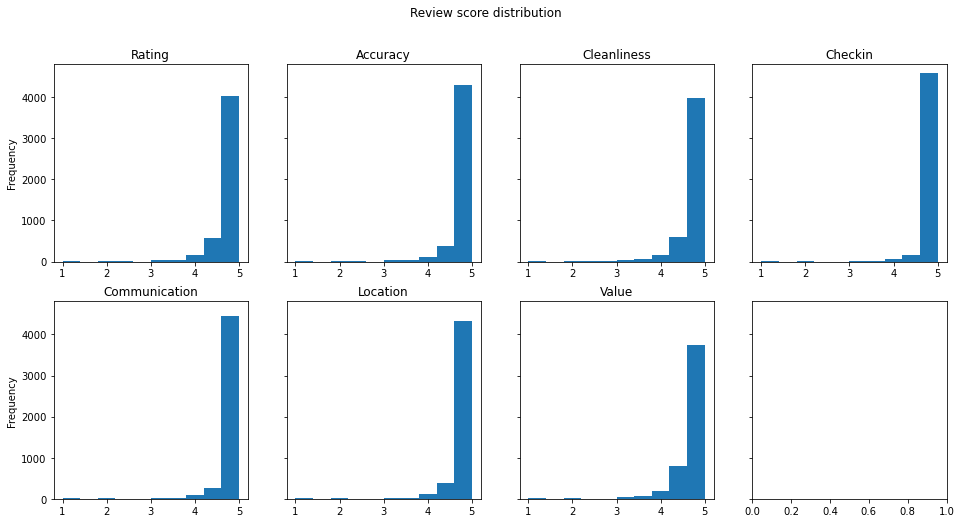

In [372]:
# review scores
col_review_score = X_train.columns[X_train.columns.str.contains('review_scores_')]

fig, axes = plt.subplots(2,4, figsize=(16,8), sharey=True)
ax1 = X_train['review_scores_rating'].plot(kind='hist', ax=axes[0,0])
ax2 = X_train['review_scores_accuracy'].plot(kind='hist', ax=axes[0,1])
ax3 = X_train['review_scores_cleanliness'].plot(kind='hist', ax=axes[0,2])
ax4 = X_train['review_scores_checkin'].plot(kind='hist', ax=axes[0,3])
ax5 = X_train['review_scores_communication'].plot(kind='hist', ax=axes[1,0])
ax6 = X_train['review_scores_location'].plot(kind='hist', ax=axes[1,1])
ax7 = X_train['review_scores_value'].plot(kind='hist', ax=axes[1,2])

ax1.set_title('Rating')
ax2.set_title('Accuracy')
ax3.set_title('Cleanliness')
ax4.set_title('Checkin')
ax5.set_title('Communication')
ax6.set_title('Location')
ax7.set_title('Value')

plt.suptitle('Review score distribution')
; 
plt.savefig('../Plots/reviewscores_hist.png', bbox_inches='tight')

In [366]:
pd.DataFrame(X_train[col_review_score].mean().sort_values(ascending=False), columns=['Average'])

,Average
review_scores_checkin,4.874075
review_scores_communication,4.847584
review_scores_location,4.805054
review_scores_accuracy,4.800678
review_scores_rating,4.750422
review_scores_cleanliness,4.748381
review_scores_value,4.681582


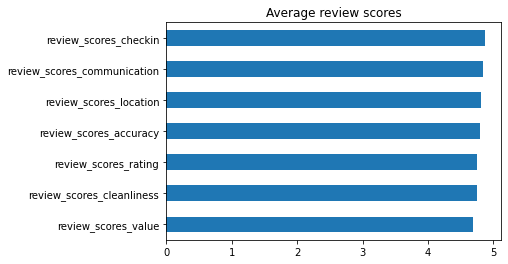

In [373]:
X_train[col_review_score].mean().sort_values(ascending=True).plot(kind='barh', 
                                                                  title='Average review scores');
plt.savefig('../Plots/reviewscores_barh.png', bbox_inches='tight')


In [374]:
# flag columns
col_flags = ['neighborhood_overview_f','host_about_f','host_response_time_f',
             'host_response_rate_f','host_acceptance_rate_f','host_neighbourhood_f']

pd.DataFrame(X_train[col_flags].mean().sort_values(ascending=False), columns=['Avaiability proportion'])

,Avaiability proportion
host_acceptance_rate_f,0.892396
host_response_time_f,0.883788
host_response_rate_f,0.883788
host_neighbourhood_f,0.870670
neighborhood_overview_f,0.723099
host_about_f,0.698299


#### Target variable: 30-day vacancy

##### 30-day vacancy distribution

In [375]:
train['availability_30'].mean()

16.950194712031156

In [376]:
train.groupby('county')['availability_30'].mean()

county
San Francisco    15.621802
San Mateo        16.968839
Santa Clara      18.121662
Name: availability_30, dtype: float64

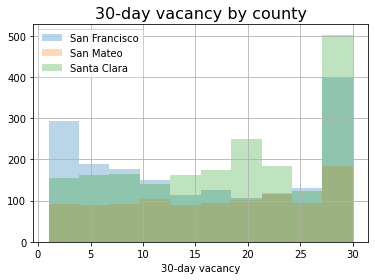

In [379]:
train.groupby('county')['availability_30'].hist(alpha=0.3, legend=True)
plt.legend()
plt.title('30-day vacancy by county', fontsize=16)
plt.xlabel('30-day vacancy');

plt.savefig('../Plots/avail30_bycounty_hist.png')

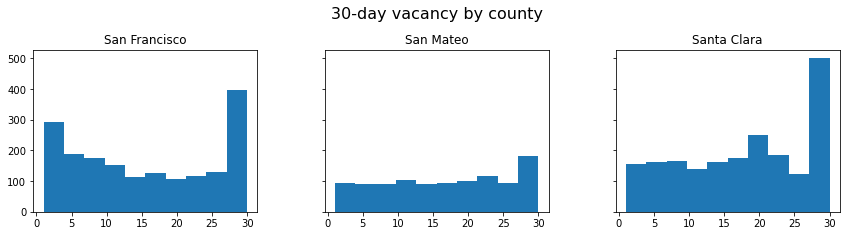

In [403]:
train.hist(column='availability_30', by='county', figsize=(14,3), layout=(1,3), xrot=0, legend=False, sharex=True, sharey=True)
;
plt.suptitle('30-day vacancy by county', x=0.5, y=1.1, fontsize=16);
plt.savefig('../Plots/avail30_bycounty_hist2.png', bbox_inches='tight')

**Observation**: 
1. On avderage, Santa Clara's 30-day vacancy is highest and that of San Francisco is the lowest.

##### 30-day vacancy by some features

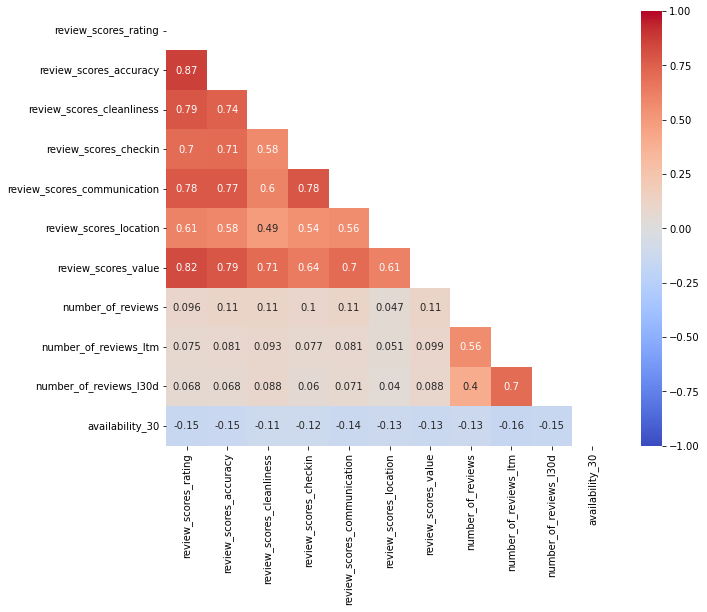

In [413]:
plt.figure(figsize=(10,8))

mask = np.zeros_like(train[list(col_review_score) + list(col_review_count) + ['availability_30']].corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(train[list(col_review_score) + list(col_review_count) + ['availability_30']].corr(),
            annot=True, 
            vmin = -1,
            vmax = 1,
            mask = mask,
            cmap='coolwarm');
plt.savefig('../Plots/corr_avail30_reviewfeatures_heat_triagle.png', bbox_inches='tight')


**Obesrvation**: Among reviews on specific aspects, 
- listing info accuracy and perceived value are most correlated to the overall rating
- location is least correlated to the overall rating.

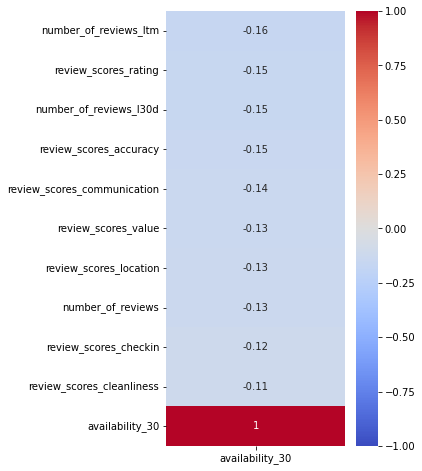

In [414]:
plt.figure(figsize=(4,8))

sns.heatmap(train[list(col_review_score) + list(col_review_count) + ['availability_30']].corr()[['availability_30']].sort_values('availability_30'),
            annot=True, 
            vmin = -1,
            vmax = 1,
            cmap='coolwarm');
plt.savefig('../Plots/corr_avail30_reviewfeatures_heat.png', bbox_inches='tight')

**Obesrvation**: 
1. 30-day vacancy is negative related to all review scores. This makes sense, as the listings with better reviews will look more attractive to potential guests and have less vacancy. 
> - The overall rating has the highest correlaton with the 30-day vacancy among all review related features.
2. 30-day vacancy is negative related to all review counts. High review counts could also indicate high occupancy rate and/or high turnaround rate.

In [415]:
# inclusion of some information on the listing: neighborhood overivew, host intro, host response time, etc
train[col_flags + ['availability_30']].corr()[['availability_30']].sort_values('availability_30',ascending=False)

,availability_30
availability_30,1.000000
host_neighbourhood_f,-0.039809
host_about_f,-0.060706
neighborhood_overview_f,-0.072104
host_response_time_f,-0.107242
host_response_rate_f,-0.107242
host_acceptance_rate_f,-0.130134


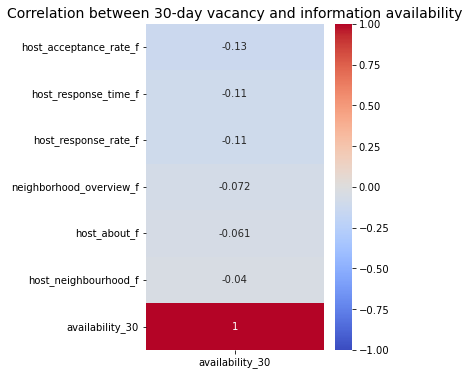

In [424]:
plt.figure(figsize=(4,6))
sns.heatmap(train[col_flags + ['availability_30']].corr()[['availability_30']].sort_values('availability_30'),
            annot=True, 
            vmin = -1, 
            vmax = 1,
            cmap='coolwarm')
plt.title('Correlation between 30-day vacancy and information availability', fontsize=14);
plt.savefig('../Plots/corr_avail30_flagcols_heat.png', bbox_inches='tight')

**Observation**: Listings with information on host acceptance rate and and response time have lower 30-day vacancy. 

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].mean()

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].hist(alpha=0.3, legend=True)
plt.title('30-day vacancy by ');

In [ ]:
plt.figure(figsize=(5,3))

train.groupby('neighborhood_overview_f')['availability_30'].mean().plot(kind='bar', alpha=0.3, rot=0)
plt.title('30-day vacancy')
plt.xlabel(None)
plt.xticks(ticks  = [0,1],
           labels = ['no neighborhood review','with neighborhood review'])
;

In [ ]:
train.groupby('neighborhood_overview_f')['availability_30'].mean()

In [ ]:
train.groupby('host_about_f')['availability_30'].mean()

In [ ]:
plt.figure(figsize=(5,3))

train.groupby('host_about_f')['availability_30'].mean().plot(kind='bar', alpha=0.3, rot=0)
plt.title('30-day vacancy')
plt.xlabel(None)
plt.xticks(ticks  = [0,1],
           labels = ['no neighborhood review','with neighborhood review'])
;

## Modeling

The availabilities in the next 30, 60 and 90 days were tried as the target variable. The 30-day availability worked better for model performancewhich makes sense as its the closest future. So decided to use availability_30 as the target.

In [193]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4879, 38), (4879,), (1627, 38), (1627,))

In [195]:
# get the data shape after one hot encoding 

# https://contrib.scikit-learn.org/category_encoders/onehot.html
#ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
#X_train_ohe = ohe.fit_transform(X_train, use_cat_names=True)
#X_train_ohe.shape

### Baseline model

In [196]:
# train set
print(f'Average listing price (train): {round(y_train.mean(), 2)}')
price_pred_base_train = np.full((y_train.shape[0], 1), y_train.mean())

price_pred_base_mse_train = metrics.mean_squared_error(y_train, price_pred_base_train)
print(f'price_pred_base_mse_train: {round(price_pred_base_mse_train, 4)}')
print()

# test set
print(f'Average listing price (test): {round(y_test.mean(), 2)}')
price_pred_base_test = np.full((y_test.shape[0], 1), y_test.mean())

price_pred_base_mse_test = metrics.mean_squared_error(y_test, price_pred_base_test)
print(f'price_pred_base_mse_test: {round(price_pred_base_mse_test, 4)}')


Average listing price (train): 16.95
price_pred_base_mse_train: 94.7495

Average listing price (test): 16.99
price_pred_base_mse_test: 94.1358


### Random Forest regressor

#### Default parameter values

In [197]:
m21_pipe_rf_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_rf_base.fit(X_train, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_rf_base_pred_train = m21_pipe_rf_base.predict(X_train)
m21_pipe_rf_base_pred_test = m21_pipe_rf_base.predict(X_test)

# evaluate
m21_pipe_rf_base_R2_train = m21_pipe_rf_base.score(X_train, y_train)
m21_pipe_rf_base_R2_test = m21_pipe_rf_base.score(X_test, y_test)
print('m21_pipe_rf_base_R2_train: ', round(m21_pipe_rf_base_R2_train, 4))
print('m21_pipe_rf_base_R2_test: ', round(m21_pipe_rf_base_R2_test, 4))

m21_pipe_rf_base_mse_train = metrics.mean_squared_error(y_train, m21_pipe_rf_base_pred_train)
m21_pipe_rf_base_mse_test = metrics.mean_squared_error(y_test, m21_pipe_rf_base_pred_test)
print('m21_pipe_rf_base_mse_train', round(m21_pipe_rf_base_mse_train, 4))
print('m21_pipe_rf_base_mse_test', round(m21_pipe_rf_base_mse_test, 4))

2022-02-05 18:03:51.290372
2022-02-05 18:03:52.305850

m21_pipe_rf_base_R2_train:  0.8934
m21_pipe_rf_base_R2_test:  0.2142
m21_pipe_rf_base_mse_train 10.1046
m21_pipe_rf_base_mse_test 73.9753


In [252]:
# import joblib

# Save
m21_pipe_rf_base_joblib_filename = '../Models/m21_pipe_rf_base_joblib_poor.pkl'
joblib.dump(m21_pipe_rf_base, m21_pipe_rf_base_joblib_filename)

['../Models/m21_pipe_rf_base_joblib_poor.pkl']

In [199]:
# feature importance
m21_pipe_rf_base_feature_importance = pd.DataFrame({'feature': m21_pipe_rf_base['ohe'].get_feature_names(),
                                             'importance': m21_pipe_rf_base['rf'].feature_importances_})

m21_pipe_rf_base_feature_importance.to_csv('../Data/m21_pipe_rf_base_feature_importance.csv')
m21_pipe_rf_base_feature_importance.sort_values('importance', ascending=False).head(10)

,feature,importance
90,number_of_reviews_ltm,0.123602
99,price_pred,0.074611
100,random,0.067009
98,price,0.063625
71,minimum_nights,0.054186
89,number_of_reviews,0.049258
88,review_scores_value,0.042069
87,review_scores_location,0.036247
84,review_scores_cleanliness,0.032098
83,review_scores_accuracy,0.031399


**Observation**: 
1. Only 3 features are more important than the 'random' feature. This is very weird.

**Decision**: Fit the model with these the top 20 features 

In [206]:
# retrain with the top n features

# the top-n feature list
feature_list = m21_pipe_rf_base_feature_importance.sort_values('importance', ascending=False).head(21)['feature']
feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()

# try this model
m21_pipe_rf_base_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_rf_base_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_rf_base_top_pred_train = m21_pipe_rf_base_top.predict(X_train_ohe_top)
m21_pipe_rf_base_top_pred_test = m21_pipe_rf_base_top.predict(X_test_ohe_top)

# evaluate
m21_pipe_rf_base_top_R2_train = m21_pipe_rf_base_top.score(X_train_ohe_top, y_train)
m21_pipe_rf_base_top_R2_test = m21_pipe_rf_base_top.score(X_test_ohe_top, y_test)
print('m21_pipe_rf_base_top_R2_train: ', round(m21_pipe_rf_base_top_R2_train, 4))
print('m21_pipe_rf_base_top_R2_test: ', round(m21_pipe_rf_base_top_R2_test, 4))

m21_pipe_rf_base_top_mse_train = metrics.mean_squared_error(y_train, m21_pipe_rf_base_top_pred_train)
m21_pipe_rf_base_top_mse_test = metrics.mean_squared_error(y_test, m21_pipe_rf_base_top_pred_test)
print('m21_pipe_rf_base_top_mse_train', round(m21_pipe_rf_base_top_mse_train, 4))
print('m21_pipe_rf_base_top_mse_test', round(m21_pipe_rf_base_top_mse_test, 4))

2022-02-05 18:10:00.305473
2022-02-05 18:10:00.831582

m21_pipe_rf_base_top_R2_train:  0.8892
m21_pipe_rf_base_top_R2_test:  0.1834
m21_pipe_rf_base_top_mse_train 10.4959
m21_pipe_rf_base_top_mse_test 76.875


**Observation**: Keeping only top 20 features doesn't improve the overfitting issue and the test R2 dropped a bit.

#### GridSearchCV

In [208]:
m21_pipe_rf = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m21_pipe_rf_params = {
    'rf__n_estimators': [400, 600],
    'rf__max_depth': [4, 8, 12],
    'rf__min_samples_split': [10, 20],
    'rf__min_samples_leaf': [5,10],
    #'rf__ccp_alpha': [0.0, 0.05, 0.1],
    'rf__max_features': [20, 60]
}

m21_gs_rf = GridSearchCV(m21_pipe_rf,
                        m21_pipe_rf_params,
                        cv=5
                       )

print(datetime.datetime.now())

m21_gs_rf.fit(X_train, y_train)

print(datetime.datetime.now())

2022-02-05 18:12:42.247072
2022-02-05 18:16:40.483858


In [209]:
m21_gs_rf_pred_train = m21_gs_rf.predict(X_train)
m21_gs_rf_pred_test = m21_gs_rf.predict(X_test)

# evaluate
m21_gs_rf_R2_train = m21_gs_rf.score(X_train, y_train)
m21_gs_rf_R2_test = m21_gs_rf.score(X_test, y_test)
print('m21_gs_rf_R2_train: ' + f'{round(m21_gs_rf_R2_train, 4)}')
print('m21_gs_rf_R2_test:  ' + f'{round(m21_gs_rf_R2_test, 4)}')

m21_gs_rf_mse_train = metrics.mean_squared_error(y_train, m21_gs_rf_pred_train)
m21_gs_rf_mse_test = metrics.mean_squared_error(y_test, m21_gs_rf_pred_test)
print(f'm21_gs_rf_mse_train: {round(m21_gs_rf_mse_train, 4)}')
print(f'm21_gs_rf_mse_test:  {round(m21_gs_rf_mse_test, 4)}')

m21_gs_rf.best_estimator_

m21_gs_rf_R2_train: 0.5866
m21_gs_rf_R2_test:  0.2212
m21_gs_rf_mse_train: 39.1741
m21_gs_rf_mse_test:  73.3145


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=12, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=600, n_jobs=-1,
                                       random_state=42))])

In [211]:
m21_gs_rf_feature_importance = pd.DataFrame({'feature': m21_gs_rf.best_estimator_['ohe'].get_feature_names(),
                                             'importance': m21_gs_rf.best_estimator_['rf'].feature_importances_})

m21_gs_rf_feature_importance.to_csv('../Data/m21_gs_rf_feature_importance.csv')
m21_gs_rf_feature_importance.sort_values('importance', ascending=False).head(10)

,feature,importance
90,number_of_reviews_ltm,0.156926
99,price_pred,0.079215
71,minimum_nights,0.069587
98,price,0.059911
100,random,0.056097
89,number_of_reviews,0.047736
88,review_scores_value,0.043702
91,number_of_reviews_l30d,0.038623
82,review_scores_rating,0.034507
87,review_scores_location,0.034502


**Observation**: 
1. With the grid search, the R2 of the train set dropped significantly and that of the test set improved a bit. 
2. The 'random' column is still ranked very high compared to other features.

In [213]:
# the top-20 feature list
feature_list = m21_pipe_rf_base_feature_importance.sort_values('importance', ascending=False).head(21)['feature']
#feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top20 = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top20 = X_test_ohe[feature_list].copy()


In [219]:
m21_pipe_rf_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
                     ])

m21_pipe_rf_top_params = {
    'rf__n_estimators': [400, 800]
    ,'rf__max_depth': [4, 8, 12]
    ,'rf__min_samples_split': [10, 20]
    ,'rf__min_samples_leaf': [5]
    #,'rf__ccp_alpha': [0.0, 0.1]
    #,'rf__max_features': [15,20]
}

m21_gs_rf_top = GridSearchCV(m21_pipe_rf_top,
                        m21_pipe_rf_top_params,
                        cv=5
                       )

print(datetime.datetime.now())

m21_gs_rf_top.fit(X_train_ohe_top, y_train)

print(datetime.datetime.now())

2022-02-05 20:22:56.319213
2022-02-05 20:24:19.717411


In [222]:
m21_gs_rf_top_pred_train = m21_gs_rf_top.predict(X_train_ohe_top)
m21_gs_rf_top_pred_test = m21_gs_rf_top.predict(X_test_ohe_top)

# evaluate
m21_gs_rf_top_R2_train = m21_gs_rf_top.score(X_train_ohe_top, y_train)
m21_gs_rf_top_R2_test = m21_gs_rf_top.score(X_test_ohe_top, y_test)
print('m21_gs_rf_top_R2_train: ' + f'{round(m21_gs_rf_top_R2_train, 4)}')
print('m21_gs_rf_top_R2_test:  ' + f'{round(m21_gs_rf_top_R2_test, 4)}')

m21_gs_rf_top_mse_train = metrics.mean_squared_error(y_train, m21_gs_rf_top_pred_train)
m21_gs_rf_top_mse_test = metrics.mean_squared_error(y_test, m21_gs_rf_top_pred_test)
print('m21_gs_rf_top_mse_train: ' + f'{round(m21_gs_rf_top_mse_train, 4)}')
print('m21_gs_rf_top_mse_test:  ' + f'{round(m21_gs_rf_top_mse_test, 4)}')

m21_gs_rf.best_estimator_

m21_gs_rf_top_R2_train: 0.5954
m21_gs_rf_top_R2_test:  0.1943
m21_gs_rf_top_mse_train: 38.336
m21_gs_rf_top_mse_test:  75.8488


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('rf',
                 RandomForestRegressor(max_depth=12, max_features=60,
                                       min_samples_leaf=5, min_samples_split=10,
                                       n_estimators=600, n_jobs=-1,
                                       random_state=42))])

**Observation**: The performance is worse than without dropping other features.

#### Save (and reload) m2_gs_rf with joblib

In [253]:
# import joblib

# Save
joblib.dump(m21_gs_rf_top, '../Models/m21_gs_rf_top_joblib_poor.pkl')

# Reload
# m21_gs_rf_top_joblib = joblib.load(m21_gs_rf_top_joblib_filename)

# Predict & Evaluate
# m21_gs_rf_top_joblib_pred_test = m21_gs_rf_top_joblib.predict(X_test)
# round(m21_gs_rf_top_joblib.score(X_test_ohe_top, y_test), 4)

['../Models/m21_gs_rf_top_joblib_poor.pkl']

### XGBoost tree regressor

#### Baseline - default parameter values

In [226]:
# Baseline model
m21_pipe_xgb_base = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(max_depth=6, n_estimators=100, random_state=42, n_jobs=-1)) # by default, max_depth is 6, 
])

m21_pipe_xgb_base.fit(X_train, y_train)
m21_pipe_xgb_base_pred_train = m21_pipe_xgb_base.predict(X_train)
m21_pipe_xgb_base_pred_test = m21_pipe_xgb_base.predict(X_test)

m21_pipe_xgb_base_R2_train = m21_pipe_xgb_base.score(X_train, y_train)
m21_pipe_xgb_base_R2_test = m21_pipe_xgb_base.score(X_test, y_test)
print('m21_pipe_xgb_base_R2_train: ', round(m21_pipe_xgb_base_R2_train, 4))
print('m21_pipe_xgb_base_R2_test: ', round(m21_pipe_xgb_base_R2_test, 4))

m21_pipe_xgb_base_mse_train = metrics.mean_squared_error(y_train, m21_pipe_xgb_base_pred_train)
m21_pipe_xgb_base_mse_test = metrics.mean_squared_error(y_test, m21_pipe_xgb_base_pred_test)
print('m21_pipe_xgb_base_mse_train', round(m21_pipe_xgb_base_mse_train, 4))
print('m21_pipe_xgb_base_mse_test', round(m21_pipe_xgb_base_mse_test, 4))

m21_pipe_xgb_base_R2_train:  0.8724
m21_pipe_xgb_base_R2_test:  0.1896
m21_pipe_xgb_base_mse_train 12.0858
m21_pipe_xgb_base_mse_test 76.2892


In [229]:
# feature importance
m21_pipe_xgb_base_feature_importance = pd.DataFrame({'feature': m21_pipe_xgb_base['ohe'].get_feature_names(),
                                             'importance': m21_pipe_xgb_base['xgb'].feature_importances_})

m21_pipe_xgb_base_feature_importance.to_csv('../Data/m21_pipe_xgb_base_feature_importance.csv')
m21_pipe_xgb_base_feature_importance.sort_values('importance', ascending=False).head(10)

# There are 32 features that are more important than 'random'.

,feature,importance
96,host_acceptance_rate_f,0.064385
90,number_of_reviews_ltm,0.039708
46,county_San Francisco,0.027775
54,property_type_recoded_Room in boutique hotel,0.023661
71,minimum_nights,0.022754
81,Pool,0.022229
17,neighborhood_recoded_Inner Sunset,0.017947
78,Outdoor_furniture,0.017756
91,number_of_reviews_l30d,0.017446
69,bathroom_type_shared,0.017318


In [231]:
# the top32 feature list
feature_list = m21_pipe_xgb_base_feature_importance.sort_values('importance', ascending=False).head(33)['feature']
#feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()


# try this model
m21_pipe_xgb_base_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(n_estimators=300, max_depth=4, eta=0.05, reg_lambda=50, reg_alpha=50,random_state=42, n_jobs=-1))
])

# train model
print(datetime.datetime.now())
m21_pipe_xgb_base_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())
print()

# predict
m21_pipe_xgb_base_top_pred_train = m21_pipe_xgb_base_top.predict(X_train_ohe_top)
m21_pipe_xgb_base_top_pred_test = m21_pipe_xgb_base_top.predict(X_test_ohe_top)

# evaluate
m21_pipe_xgb_base_top_R2_train = m21_pipe_xgb_base_top.score(X_train_ohe_top, y_train)
m21_pipe_xgb_base_top_R2_test = m21_pipe_xgb_base_top.score(X_test_ohe_top, y_test)
print('m21_pipe_xgb_base_top_R2_train: ', round(m21_pipe_xgb_base_top_R2_train, 4))
print('m21_pipe_xgb_base_top_R2_test: ', round(m21_pipe_xgb_base_top_R2_test, 4))

m21_pipe_xgb_base_top_mse_train = metrics.mean_squared_error(y_train, m21_pipe_xgb_base_top_pred_train)
m21_pipe_xgb_base_top_mse_test = metrics.mean_squared_error(y_test, m21_pipe_xgb_base_top_pred_test)
print('m21_pipe_xgb_base_top_mse_train', round(m21_pipe_xgb_base_top_mse_train, 4))
print('m21_pipe_xgb_base_top_mse_test', round(m21_pipe_xgb_base_top_mse_test, 4))

2022-02-05 20:52:04.158889
2022-02-05 20:52:05.378615

m21_pipe_xgb_base_top_R2_train:  0.3691
m21_pipe_xgb_base_top_R2_test:  0.2109
m21_pipe_xgb_base_top_mse_train 59.7736
m21_pipe_xgb_base_top_mse_test 74.2844


**Observation**: Keeping only the top 32 features reduced the overfitting significantly, though the model's R2 is still low.

#### GridSearchCV

In [232]:
# build the model
m21_pipe_xgb = Pipeline([
    ('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
])

m21_pipe_xgb_params = {
    #'xgb__booster': ['gbtree','gblinear'],
    'xgb__n_estimators': [300, 400],
    'xgb__eta': [0.01, 0.03, 0.05],
    'xgb__reg_alpha': [30, 40, 50],
    'xgb__reg_lambda': [30, 40, 50],
    'xgb__max_depth': [4,6,8],
}

m21_gs_xgb = GridSearchCV(m21_pipe_xgb,
                         m21_pipe_xgb_params, 
                         cv = 5)

# train the model
print(datetime.datetime.now())
m21_gs_xgb.fit(X_train, y_train)
print(datetime.datetime.now())

# predict
m21_gs_xgb_pred_train = m21_gs_xgb.predict(X_train)
m21_gs_xgb_pred_test = m21_gs_xgb.predict(X_test)

# evaluate
m21_gs_xgb_R2_train = m21_gs_xgb.score(X_train, y_train)
m21_gs_xgb_R2_test = m21_gs_xgb.score(X_test, y_test)
print(f'm21_gs_xgb_R2_train: {round(m21_gs_xgb_R2_train, 4)}')
print(f'm21_gs_xgb_R2_test: {round(m21_gs_xgb_R2_test, 4)}')

m21_gs_xgb_mse_train = metrics.mean_squared_error(y_train, m21_gs_xgb_pred_train)
m21_gs_xgb_mse_test = metrics.mean_squared_error(y_test, m21_gs_xgb_pred_test)
print(f'm21_gs_xgb_mse_train: {round(m21_gs_xgb_mse_train, 4)}')
print(f'm21_gs_xgb_mse_test: {round(m21_gs_xgb_mse_test)}')

m21_gs_xgb.best_estimator_

2022-02-05 20:56:24.813959
2022-02-05 21:40:05.303547
m21_gs_xgb_R2_train: 0.5992030080772492
m21_gs_xgb_R2_test: 0.22864507966221648
m21_gs_xgb_mse_train: 37.975321717810075
m21_gs_xgb_mse_test: 72.61211422384899


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.03, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.0299999993, max_delta_step=0,
                              max_depth=8, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=42, reg_alpha=30, reg_lambda=50,
              

In [233]:
# feature importance
m21_gs_xgb_feature_importance = pd.DataFrame({'feature': m21_gs_xgb.best_estimator_['ohe'].get_feature_names(),
                                         'importance': m21_gs_xgb.best_estimator_['xgb'].feature_importances_})

m21_gs_xgb_feature_importance.to_csv('../Data/m21_gs_xgb_feature_importance.csv')
m21_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(20)

# There are 47 features that are more important than the 'random' column

,feature,importance
90,number_of_reviews_ltm,0.037494
96,host_acceptance_rate_f,0.036391
69,bathroom_type_shared,0.028763
17,neighborhood_recoded_Inner Sunset,0.026583
51,property_type_recoded_Entire rental unit,0.023729
46,county_San Francisco,0.020582
52,property_type_recoded_Entire guest suite,0.019846
71,minimum_nights,0.019076
63,property_type_recoded_Entire serviced apartment,0.016880
27,neighborhood_recoded_Noe Valley,0.016133


In [234]:
# retrain the model with the top 45 features

# the top-45feature list
feature_list = m21_gs_xgb_feature_importance.sort_values('importance', ascending=False).head(46)['feature']
#feature_list = [feature for feature in feature_list if feature != 'random']

# create the X_train with only these features
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe_top = X_train_ohe[feature_list].copy()

X_test_ohe = ohe.transform(X_test)
X_test_ohe_top = X_test_ohe[feature_list].copy()

# build the model
m21_pipe_xgb_top = Pipeline([
    #('ohe', ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')),
    ('xgb', XGBRegressor(random_state=42, n_jobs=-1))
                     ])

m21_gs_xgb_top_params = {
    #'xgb__booster': ['gbtree','gblinear'],
    'xgb__n_estimators': [300, 400],
    'xgb__eta': [0.01, 0.03, 0.05],
    'xgb__reg_alpha': [30, 40, 50],
    'xgb__reg_lambda': [30, 40, 50],
    'xgb__max_depth': [4,6,8],
}

m21_gs_xgb_top = GridSearchCV(m21_pipe_xgb_top,
                        m21_gs_xgb_top_params,
                        cv=5
                       )

# train the model
print(datetime.datetime.now())
m21_gs_xgb_top.fit(X_train_ohe_top, y_train)
print(datetime.datetime.now())

# predict
m21_gs_xgb_top_pred_train = m21_gs_xgb_top.predict(X_train_ohe_top)
m21_gs_xgb_top_pred_test = m21_gs_xgb_top.predict(X_test_ohe_top)

# evaluate
m21_gs_xgb_top_R2_train = m21_gs_xgb_top.score(X_train_ohe_top, y_train)
m21_gs_xgb_top_R2_test = m21_gs_xgb_top.score(X_test_ohe_top, y_test)
print(f'm21_gs_xgb_top_R2_train: {round(m21_gs_xgb_top_R2_train, 4)}')
print(f'm21_gs_xgb_top_R2_test:  {round(m21_gs_xgb_top_R2_test, 4)}')

m21_gs_xgb_top_mse_train = metrics.mean_squared_error(y_train, m21_gs_xgb_top_pred_train)
m21_gs_xgb_top_mse_test = metrics.mean_squared_error(y_test, m21_gs_xgb_top_pred_test)
print(f'm21_gs_xgb_top_mse_train: {round(m21_gs_xgb_top_mse_train, 4)}')
print(f'm21_gs_xgb_top_mse_test:  {round(m21_gs_xgb_top_mse_test, 4)}')

m21_gs_xgb.best_estimator_

2022-02-05 22:25:21.049141
2022-02-05 22:55:20.089449
m21_gs_xgb_top_R2_train: 0.4759
m21_gs_xgb_top_R2_test:  0.2184
m21_gs_xgb_top_mse_train: 49.6594
m21_gs_xgb_top_mse_test:  73.5768


Pipeline(steps=[('ohe',
                 OneHotEncoder(cols=['neighborhood_recoded', 'county',
                                     'property_type_recoded', 'bathroom_type'],
                               use_cat_names=True)),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              eta=0.03, gamma=0, gpu_id=-1,
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.0299999993, max_delta_step=0,
                              max_depth=8, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=-1, num_parallel_tree=1, predictor='auto',
                              random_state=42, reg_alpha=30, reg_lambda=50,
              

In [239]:
# feature importance
m21_gs_xgb_top_feature_importance = pd.DataFrame({'feature': X_train_ohe_top.columns,
                                         'importance': m21_gs_xgb_top.best_estimator_['xgb'].feature_importances_})

m21_gs_xgb_top_feature_importance.to_csv('../Data/m21_gs_xgb_top_feature_importance.csv')
m21_gs_xgb_top_feature_importance.sort_values('importance', ascending=False).head(15)

,feature,importance
0,number_of_reviews_ltm,0.049890
3,neighborhood_recoded_Inner Sunset,0.047151
9,neighborhood_recoded_Noe Valley,0.039267
6,property_type_recoded_Entire guest suite,0.036121
1,host_acceptance_rate_f,0.035590
2,bathroom_type_shared,0.029771
5,county_San Francisco,0.029675
10,property_type_recoded_Room in boutique hotel,0.029211
4,property_type_recoded_Entire rental unit,0.029119
7,minimum_nights,0.027434


#### Save m21_gs_xgb with joblib

In [254]:
# import joblib

# save m21_gs_rf
joblib.dump(m21_gs_xgb, '../Models/m21_gs_xgb_joblib.pkl')
joblib.dump(m21_gs_xgb_top, '../Models/m21_gs_xgb_top_joblib.pkl')

# reload 
#m21_gs_xgb_joblib = joblib.load(m21_gs_xgb_joblib_filename)
# m21_gs_xgb_joblib

# predict & evaluate
#m21_gs_xgb_joblib_pred_test = m21_gs_xgb_joblib.predict(X_test)
#round(m21_gs_xgb_joblib.score(X_test, y_test), 4)

['../Models/m21_gs_xgb_top_joblib.pkl']

## Predict with input data

In [243]:
# Create mock input data and format it as needed by the model
input_data = {'county': 'San Francisco',
              'neighborhood_recoded': 'Russian Hill', 
              'property_type_recoded': 'Entire residential home', 
              'accommodates': 6, 
              'bedrooms': 3, 
              'beds': 3,
              'bathrooms': 2.5, 
              'bathroom_type': 'private', 
              'minimum_nights': 1, 
              'maximum_nights': 3,
              'Wifi': 1, 
              'Dedicated_workspace': 0,
              'Private_entrance': 0, 
              'Patio_or_balcony': 1, 
              'Backyard': 1, 
              'BBQ_grill': 1, 
              'Outdoor_furniture': 1,
              'Indoor_fireplace': 0, 
              'Pool': 1, 
              'review_scores_rating': 4.8,
              'review_scores_accuracy': 4.8, 
              'review_scores_cleanliness': 4.8,
              'review_scores_checkin': 4.8,
              'review_scores_communication': 4.8,
              'review_scores_location': 4.8, 
              'review_scores_value': 4.8, 
              'number_of_reviews': 4.8,
              'number_of_reviews_ltm': 20, 
              'number_of_reviews_l30d': 5,
              'neighborhood_overview_f': 1, 
              'host_about_f': 1, 
              'host_response_time_f': 0,
              'host_response_rate_f': 0, 
              'host_acceptance_rate_f': 0,
              'host_neighbourhood_f': 0
}
input_data_df = pd.DataFrame(input_data, index=[0])

# one hot encoding - even though the shape and values don't change, the column names do change
ohe = ce.one_hot.OneHotEncoder(use_cat_names=True, handle_unknown='value')
input_data_df_ohe = ohe.fit_transform(input_data_df)
print(f'shape of the input data after ohe: {input_data_df_ohe.shape}')
# input_data_df_ohe
print(f'shape of the required input data: (1, {X_train_ohe_top.shape[1]})')

# take the columns in the input data that are needed in the model
input_data_df_ohe_useful = input_data_df_ohe[X_train_ohe_top.columns.intersection(input_data_df_ohe.columns)]
print(f'shape of useful input data: {input_data_df_ohe_useful.shape})')

# create feature_list_left - the columns which are in prediction model but not in the input data
# because they are all ohe columns, they are just filled with 0 
feature_list_left = set(X_train_ohe_top.columns).difference(input_data_df_ohe.columns)
fillin_data_df = pd.DataFrame(np.zeros([1, len(feature_list_left)]), columns=feature_list_left, index=[0])
print(f'shape of the fillin data (to meet the model requirement): {fillin_data_df.shape}')

input_data_df_final = pd.concat((input_data_df_ohe_useful, fillin_data_df), axis=1)
print(f'the shape of the input data ready for modeling: {input_data_df_final.shape}')
input_data_df_final

shape of the input data after ohe: (1, 35)
shape of the required input data: (1, 46)
shape of useful input data: (1, 21))
shape of the fillin data (to meet the model requirement): (1, 25)
the shape of the input data ready for modeling: (1, 46)


,number_of_reviews_ltm,host_acceptance_rate_f,county_San Francisco,minimum_nights,number_of_reviews_l30d,property_type_recoded_Entire residential home,Patio_or_balcony,review_scores_accuracy,review_scores_value,bedrooms,...,property_type_recoded_Entire serviced apartment,property_type_recoded_Entire loft,neighborhood_recoded_Outer Richmond,neighborhood_recoded_Bernal Heights,neighborhood_recoded_Inner Sunset,property_type_recoded_Shared room in residential home,county_Santa Clara,property_type_recoded_Entire rental unit,neighborhood_recoded_Parkside,neighborhood_recoded_Redwood City
0,20,0,1,1,5,1,1,4.8,4.8,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [246]:
# load m21_gs_rf
m21_gs_xgb_top_joblib = joblib.load('../Models/m21_gs_xgb_top_joblib.pkl')
# m21_gs_xgb_top_joblib

# predict & evaluate
m21_gs_xgb_top_joblib_pred_input = m21_gs_xgb_top_joblib.predict(input_data_df_final)[0]
print('Predicted 30-day vacancy is', round(m21_gs_xgb_top_joblib_pred_input, 2), 'days.')

Predicted 30-day vacancy is 5.56 days.
